# Creating Heatmaps out of GeoSpatial Data

Heatmap is frequently used to visualize the probability density for the occurance of an event. There are some Python libraries or GIS software/tool that can be used to create a heatmap like QGIS, ArcGIS, and others. Here we shall be using *folium* a python library builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. 


Then we will write our own code to create a heatmap using the "Quartic Kernel Density Estimation Function" in Python 3 from scratch using Python common libraries like Numpy, Pandas, scipy, and a plotting framework.

## 1.0 Using Folium

Folium makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.

The library has a number of built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets with Mapbox or Cloudmade API keys. folium supports both Image, Video, GeoJSON and TopoJSON overlays.

REF: https://python-visualization.github.io/folium/#

### 1.1 Importing what's needed

In [9]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
import os

%matplotlib inline

### 1.2 Loading up the Data

I will be using the geospatial dataset which has been provided with the assignment heatmap_buy_20

In [17]:
buy20=pd.read_csv("heatmap_buy_20.csv")

buy20.head()

,longitude,latitude,weight
0,88.435715,22.595484,4000.0000
1,88.327835,22.488018,4930.3370
2,88.420050,22.628452,5992.0635
3,88.339935,22.495138,8171.4287
4,88.340150,22.501444,7649.3580


In [18]:
# Generates a base map at lattitude 22.69 and longitude 88.39
map = folium.Map([22.69, 88.39], zoom_start=11)


# Generating the heatmap Overlay
hmap = HeatMap( list(zip(buy20.latitude.values, buy20.longitude.values, buy20.weight.values)),
                   min_opacity=0.2,
                   radius=50, blur=69, 
                   max_zoom=1, 
                 )

map.add_child(hmap)

In [19]:
# Saving up the Generated map as an interactive HTML file
map.save('heatmap.html')

## 2.0 Heatmap From Scratch

As I mentioned earlier. The heatmap was create will used Kernel Density Estimation algorithm. Now let's explore how this algorithm is working, so we can tune related parameters to get a more insightful heatmap cause we understand how the result comes up. 
Now let's get Started by importing numpy, scipy and math..

In [21]:
import numpy as np
import math
import scipy.ndimage as sp

In [254]:
# Now let's generated the heatmap

lattitude = list(buy20.latitude*10)
longitude = list(buy20.longitude*10)
weights = list(buy20.weight)

In creating heatmap using KDE we need to specify the bandwidth or radius of the kernel shape and output grid size.


In [245]:
# Let's Define our Grid size and Kernel radius
grid_size=0.1
radius=0.9

To construct grid we use mesh grid. Therefore we need to find x,y minimum and maximum to generate a sequence number of x and y. These sequence numbers then will be used to construct mesh grid. To include all the dataset coverage with a little bit more space, I subtract x,y minimum with radius and add it up for x,y maximum.

In [246]:
x_min=min(longitude)
x_max=max(longitude)
y_min=min(lattitude)
y_max=max(lattitude)

# Constructing the grid
x_grid=np.arange(x_min-radius,x_max+radius,grid_size)
y_grid=np.arange(y_min-radius,y_max+radius,grid_size)
x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)

After constructing mesh grid. Next we calculate the center point for each grid. This can be done with adding x mesh and y mesh coordinate with half of grid size. The center point will be used later to calculate the distance of each grid to dataset points.

In [247]:
x_center=x_mesh+(grid_size/2)
y_center=y_mesh+(grid_size/2)

To calculate a point density or intensity we use a function called kde_quartic. We are using Quartic kernel shape, that's why it has "quartic" term in the function name. This function has two arguments: point distance(d) and kernel radius (radius).

In [248]:
# Quartic Kernel Shape
def kde_quartic(d,h):
    dn=d/h
    P=(15/16)*(1-dn**2)**2
    return P

# Gaussian Kernel Shape
def kde_gaussian(d,h):
    dn =d/h
    P=(1/np.sqrt(2*np.pi))*(np.exp(-(dn**2)/2))
    return P

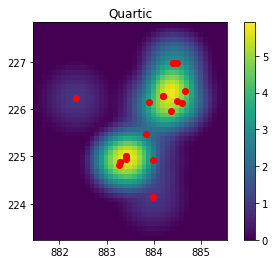

<Figure size 432x288 with 0 Axes>

In [280]:
# Quartic Kernel 

q_intensity_list=[]
for j in range(len(x_center)):
    q_intensity_row=[]
    for k in range(len(x_center[0])):
        q_kde_value_list=[]
        q_weight_value_list =[]
        for i in range(len(longitude)):
            #CALCULATE DISTANCE
            d=math.sqrt((x_center[j][k]-longitude[i])**2+(y_center[j][k]-lattitude[i])**2) 
            if d<=radius:
                p=kde_quartic(d,radius)
            else:
                p=0
            q_kde_value_list.append(p)
            
            if x_center[j][k] == longitude[i] and y_center[j][k] == lattitude[i]:
                w=weights[i]
            else:
                w=0
            q_weight_value_list.append(w)
            
        #SUM ALL INTENSITY VALUE
        q_p_total=sum(q_kde_value_list) + sum(q_weight_value_list)
        q_intensity_row.append(q_p_total)
    q_intensity_list.append(q_intensity_row)

# Drawing heatmap
q_plt = plt
q_intensity=np.array(q_intensity_list)
q_plt.plot(longitude,lattitude,'ro')
q_plt.pcolormesh(x_mesh,y_mesh,q_intensity)
q_plt.axis('scaled')
q_plt.colorbar()
q_plt.title("Quartic")
q_plt.show()
q_plt.savefig('Quartic_heatmap.png')

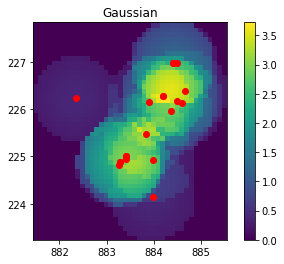

<Figure size 432x288 with 0 Axes>

In [278]:
# gaussian Kernel 

g_intensity_list=[]
for j in range(len(x_center)):
    g_intensity_row=[]
    for k in range(len(x_center[0])):
        g_kde_value_list=[]
        g_weight_value_list =[]
        for i in range(len(longitude)):
            #CALCULATE DISTANCE
            d=math.sqrt((x_center[j][k]-longitude[i])**2+(y_center[j][k]-lattitude[i])**2) 
            if d<=radius:
                p=kde_gaussian(d,radius)
            else:
                p=0
            g_kde_value_list.append(p)
            if x_mesh[j][k] in longitude and y_mesh[j][k] in lattitude:
                w=weights[i]
            else:
                w=0
            g_weight_value_list.append(w)
        
            
        
        #SUM ALL INTENSITY VALUE
        g_p_total= sum(g_kde_value_list) + sum(g_weight_value_list)
        g_intensity_row.append(g_p_total)
    g_intensity_list.append(g_intensity_row)

# Drawing heatmap
g_plt = plt
g_intensity=np.array(g_intensity_list)
g_plt.plot(longitude,lattitude,'ro')
g_plt.pcolormesh(x_mesh,y_mesh,g_intensity)
g_plt.axis('scaled')
g_plt.colorbar()
g_plt.title("Gaussian")
g_plt.show()
g_plt.savefig('gaussian_heatmap.png')

## 3.0 Refferances and Attributions
The GeoDose Website
https://www.geodose.com/2018/01/heatmap-with-kernel-density-estimation-example.html

Wikis
https://en.wikipedia.org/wiki/Kernel_density_estimation
https://brilliant.org/wiki/continuous-random-variables-probability-density/

